## Autoencoder MNIST

Este código fue tomado a partir de este repositorio de github [convolutional autoencoder in keras](# https://github.com/srihari-humbarwadi/convolutional-autoencoder-in-Keras/blob/master/CAE.py)

Es un simple autoencoder usando capas conv2dtranspose (el de final boss usa conv y upsampling que obtienen el mismo efecto, pero para probar otro modo).

Vamos a entrenarlo con MNIST para hacer cosas divertidas con él.

In [1]:

# In[1]:


from tensorflow.python.keras.layers import Conv2D, ReLU, BatchNormalization, Dense, Input, Conv2DTranspose, UpSampling2D, Flatten, Reshape
from tensorflow.python.keras.models import Model
from tensorflow.python.keras.utils import multi_gpu_model
from tensorflow.python.keras.optimizers import Nadam
from tensorflow.python.keras.callbacks import TensorBoard, ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import tensorflow as tf
import numpy as np
from tensorflow.python.keras import backend as K
from tensorflow.python.keras.datasets import mnist


# In[2]:


img_height, img_width = 28, 28
(x_train, y_train), (x_test, y_test) = mnist.load_data()
X = np.expand_dims(x_train, axis=-1)
print(X.shape)


# In[3]:


input_image = Input(shape=(img_height, img_width, 1), name='image_input')
x = Conv2D(filters=32, kernel_size=(5, 5), strides=(2, 2), padding='same', name ='encoder_conv1', activation='relu')(input_image)
x = Conv2D(filters=64, kernel_size=(5, 5), strides=(2, 2), padding='same', name ='encoder_conv2', activation='relu')(x)
x = Conv2D(filters=128, kernel_size=(3, 3), strides=(2, 2), padding='valid', name ='encoder_conv3', activation='relu')(x)
x = Flatten()(x)
encoded = Dense(units=16)(x)

input_code = Input(shape=(1, 16), name='code_input')
# y = Dense(units=16)(input_code)
y = Dense(units=1152, activation='relu')(input_code)
y = Reshape((3, 3, 128))(y)
y = Conv2DTranspose(filters=64, kernel_size=(3, 3), strides=(2, 2), padding='valid', name ='decoder_deconv1', activation='relu')(y)
y = Conv2DTranspose(filters=32, kernel_size=(5, 5), strides=(2, 2), padding='same', name ='decoder_deconv2', activation='relu')(y)
decoded_image = Conv2DTranspose(filters=1, kernel_size=(5, 5), strides=(2, 2), padding='same', name ='decoder_deconv3', activation='relu')(y)

encoder = Model(inputs = input_image, outputs = encoded, name = 'encoder')
decoder = Model(inputs = input_code, outputs = decoded_image, name = 'decoder')

cae_input = Input(shape=(img_height, img_width, 1), name='cae_input')

union = decoder(encoder(cae_input))

CAE = Model(inputs = cae_input, outputs = union, name = 'CAE')


# In[4]:


mc = ModelCheckpoint(filepath='./16 divided.h5', monitor='acc', save_best_only='True', save_weights_only='True', verbose=1)
es = EarlyStopping(monitor='loss', patience=15, verbose=1)
# rlr = ReduceLROnPlateau(monitor='loss')
callbacks = [mc, es]
CAE.compile(optimizer='adam', loss='mse', metrics=['accuracy'])


# In[ ]:

# CAE.load_weights('models/top_weights.h5')
# CAE.save('CAE.h5')
CAE.fit(X, X, epochs=100, batch_size=256, callbacks=callbacks)

11493376/11490434 [==============================] - 0s 0us/step
(60000, 28, 28, 1)
Epoch 1/100
59648/60000 [============================>.] - ETA: 0s - loss: 686093.4379 - acc: 0.4960
Epoch 00001: acc improved from -inf to 0.49746, saving model to ./16 divided.h5
60000/60000 [==============================] - 8s 142us/step - loss: 683536.8715 - acc: 0.4975
Epoch 2/100
59648/60000 [============================>.] - ETA: 0s - loss: 252742.9076 - acc: 0.7639
Epoch 00002: acc improved from 0.49746 to 0.76401, saving model to ./16 divided.h5
60000/60000 [==============================] - 6s 104us/step - loss: 252276.1472 - acc: 0.7640
Epoch 3/100
59648/60000 [============================>.] - ETA: 0s - loss: 201980.7230 - acc: 0.7765
Epoch 00003: acc improved from 0.76401 to 0.77656, saving model to ./16 divided.h5
60000/60000 [==============================] - 6s 104us/step - loss: 201721.1428 - acc: 0.7766
Epoch 4/100
59648/60000 [============================>.] - ETA: 0s - loss: 179621.

In [2]:
x_train.shape

(60000, 28, 28)

Mostramos un par de números pasados por el autoencoder

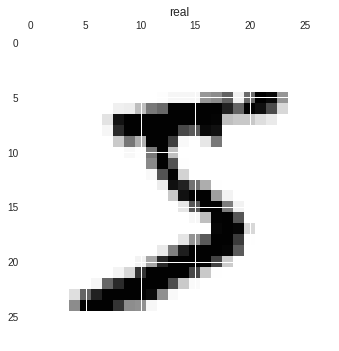

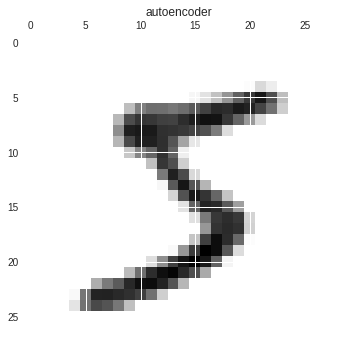

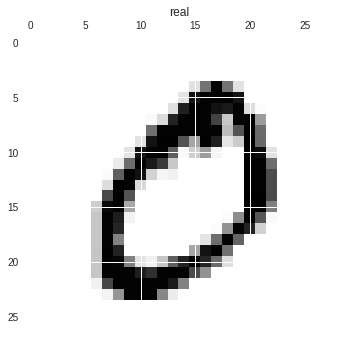

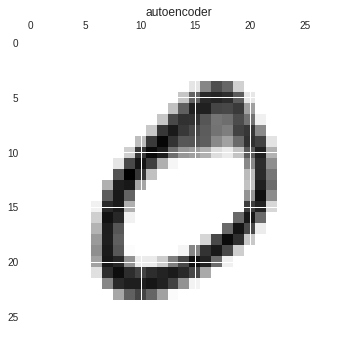

In [4]:
import matplotlib.pyplot as plt

images = X[0:2]
predictions = CAE.predict(np.array(images))

for image, pred in zip(images, predictions):
  plt.matshow(image.reshape(28, 28))
  plt.title('real')
  plt.show()
  plt.matshow(pred.reshape(28, 28))
  plt.title('autoencoder')
  plt.show()

Cómo buen autoencoder podemos interpolar números y que nos cree una interpolación que no es como al lineal que vimos en el final boss

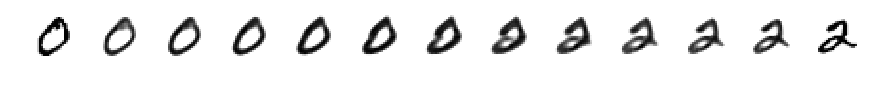

In [22]:
#@title Interpolación de números { run: "auto" }
imagen_1 = 5 #@param {type:"integer"}
imagen_2 = 1 #@param {type:"integer"}
splits = 12 #@param {type:"integer", min:0}

import matplotlib.pyplot as plt

images = [X[imagen_1], X[imagen_2]]
predictions = encoder.predict(np.array(images))

fig, axes = plt.subplots(1, splits + 1, figsize=(15,15))

axes[0].imshow(images[1].reshape(28, 28))
axes[0].axis('off')

for i, p in enumerate(np.linspace(0,1,splits)):
  
  new_code = predictions[0] * p + predictions[1] * (1 - p)
  image_pred = decoder.predict(np.array([new_code]).reshape(1,1,16))
    
  axes[i + 1].imshow(image_pred.reshape(28, 28))
  axes[i + 1].axis('off')
  
  
axes[splits].imshow(images[0].reshape(28, 28))
axes[splits].axis('off')

plt.show()
